In [42]:
import cv2
import numpy as np
from IPython.display import clear_output, Image, display
from io import StringIO
import PIL.Image
from matplotlib import pyplot as plt


def RGBCorrection(image):
    np_rgb = np.zeros(image.shape).astype(int)
    np_rgb[:,:,0] = image[:,:,2]
    np_rgb[:,:,1] = image[:,:,1]
    np_rgb[:,:,2] = image[:,:,0]
    return np_rgb

In [43]:

imagePath = "data/preprocessed/IMG_2714.jpg"
cascPath = "haarcascade_frontalface_default.xml"


In [44]:
faceCascade = cv2.CascadeClassifier(cascPath)


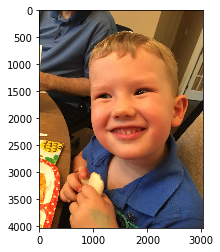

In [45]:
image = cv2.imread(imagePath)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(RGBCorrection(image))


In [46]:
faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.6,
    minSize=(150, 150)
    #flags = cv2.CV_HAAR_SCALE_IMAGE
)

In [47]:
print("Found {0} faces!".format(len(faces)))


Found 1 faces!


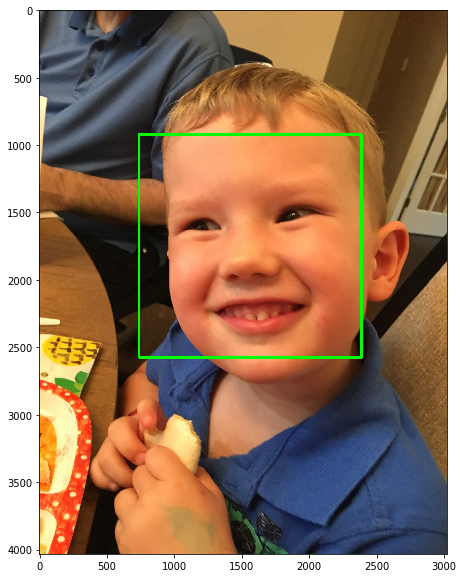

In [48]:
image2 = image
for (x, y, w, h) in faces:
    cv2.rectangle(image2, (x, y), (x+w, y+h), (0, 255, 0), 20)

plt.figure(figsize=(20,10))

plt.imshow(RGBCorrection(image2))
plt.show()

In [8]:
image.shape

(4032, 3024, 3)

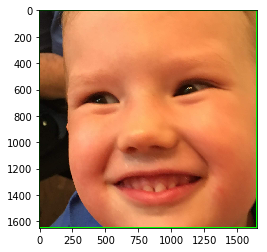

In [9]:

for box in faces:
    x, y, w, h = box
    xend = x + w
    yend = y + h

    face1 = image[y:yend, x:xend ,:]
    plt.imshow(RGBCorrection(face1))
    plt.show()



# now create a version that takes n pictures skipping mSeconds frames from webcam

In [49]:
import time
import os
from scipy.misc import toimage

def getFaceBox(box, image):
    x, y, w, h = box
    xend = x + w
    yend = y + h
    return RGBCorrection(image[y:yend, x:xend ,:])

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

def saveNfacesEveryMSeconds(label, n=10, secs=0.5, fileoffset=0):
#     first make directory that labels faces
    
    directory = os.path.dirname("data/training/" + label + "/")
    try:
        os.stat(directory)
    except:
        os.mkdir(directory)  
        
    cap = cv2.VideoCapture(0)
    
    faceArrays = []
    i = 0
                           
    while i < n:
        print("taking picture {} of {}".format(i,n))
        _, frame = cap.read()
        #face detection
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        print("we saw {} faces".format(len(faces)))
        plt.imshow(gray)
        plt.show()
        for face in faces:
            f = getFaceBox(face, frame)
            faceArrays.append(f)
            plt.imshow(f)
            plt.show()
            toimage(f, cmin=0.0, cmax = 255)\
                .save("data/training/" + label + "/{}.jpg"\
                      .format(i+fileoffset))
        time.sleep(secs)
        i += 1
    
    #teardown
    cap.release()
    cv2.destroyAllWindows()
                           
    return faceArrays
                           

taking picture 0 of 20
we saw 0 faces


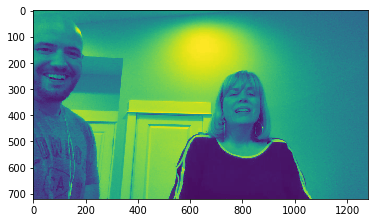

taking picture 1 of 20
we saw 0 faces


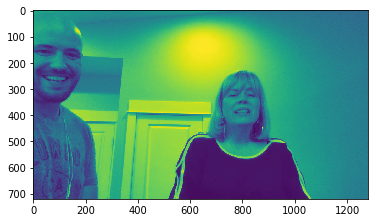

taking picture 2 of 20
we saw 1 faces


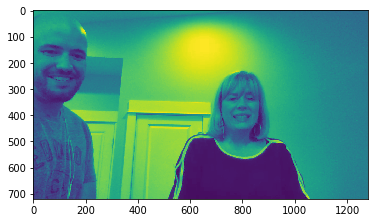

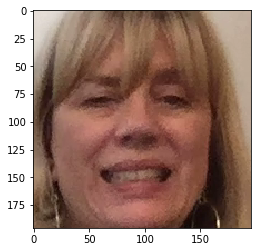

/Users/jwortz/anaconda3/envs/ThreeSix/lib/python3.6/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


taking picture 3 of 20
we saw 1 faces


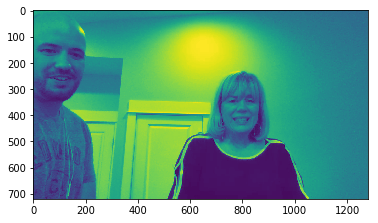

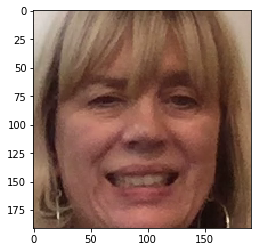

taking picture 4 of 20
we saw 1 faces


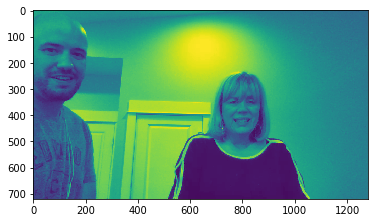

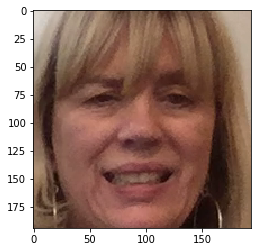

taking picture 5 of 20
we saw 1 faces


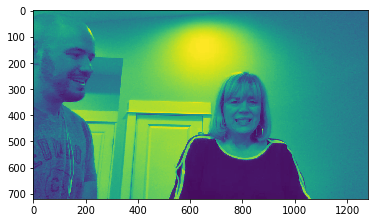

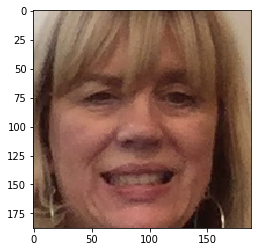

taking picture 6 of 20
we saw 1 faces


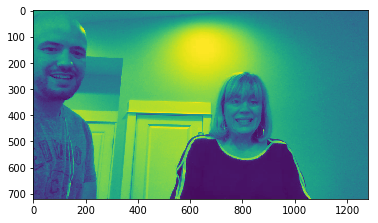

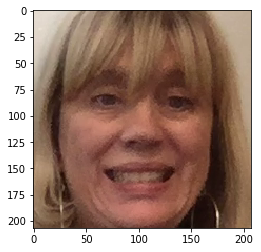

taking picture 7 of 20
we saw 1 faces


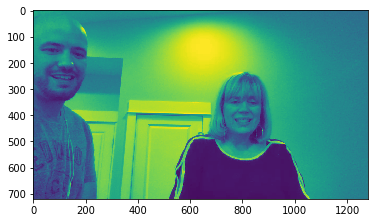

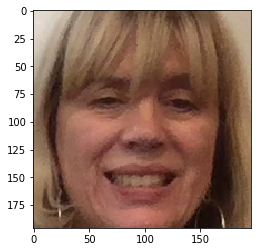

taking picture 8 of 20
we saw 1 faces


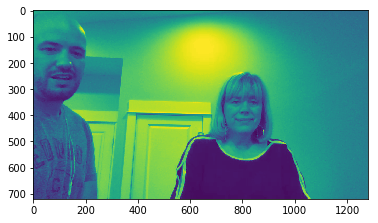

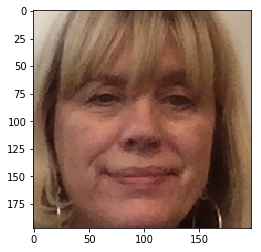

taking picture 9 of 20
we saw 1 faces


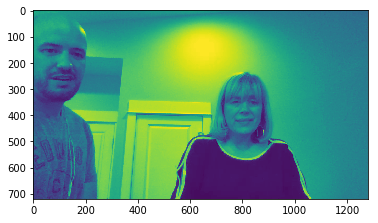

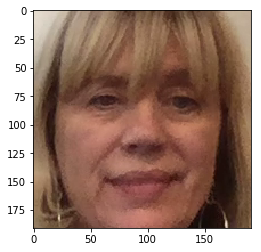

taking picture 10 of 20
we saw 1 faces


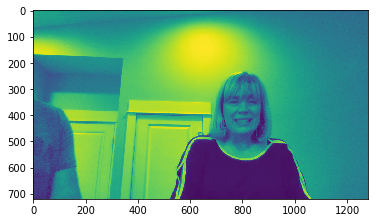

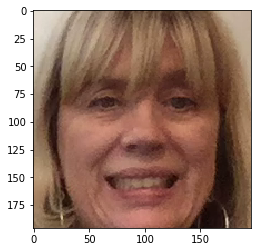

taking picture 11 of 20
we saw 0 faces


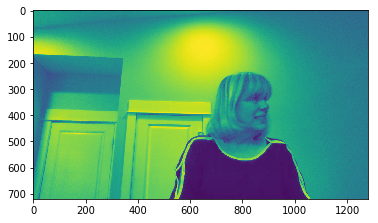

taking picture 12 of 20
we saw 0 faces


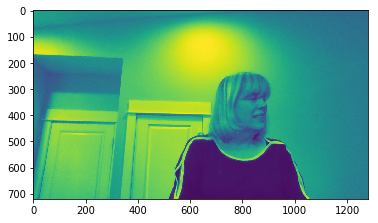

taking picture 13 of 20
we saw 1 faces


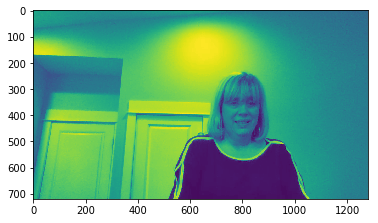

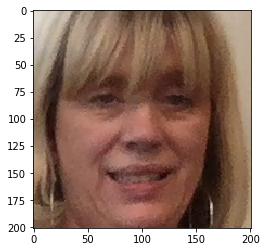

taking picture 14 of 20
we saw 1 faces


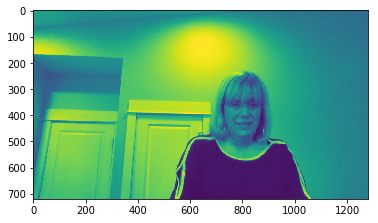

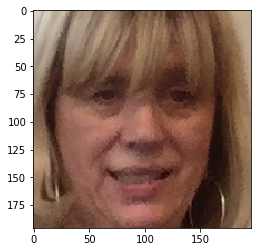

taking picture 15 of 20
we saw 1 faces


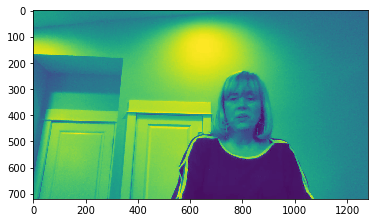

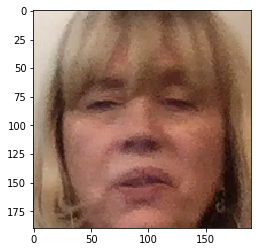

taking picture 16 of 20
we saw 1 faces


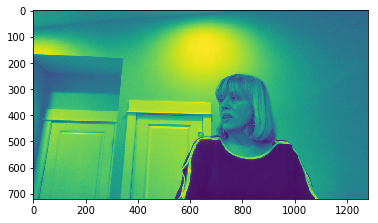

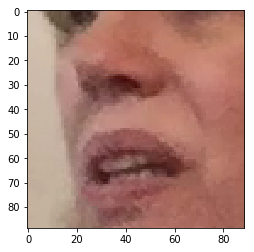

taking picture 17 of 20
we saw 1 faces


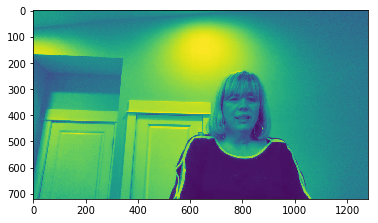

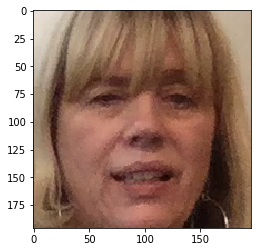

taking picture 18 of 20
we saw 0 faces


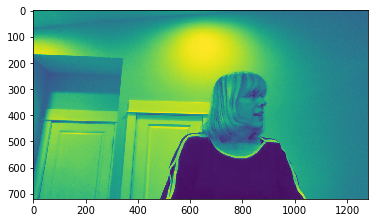

taking picture 19 of 20
we saw 0 faces


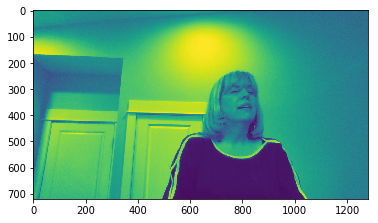

In [51]:
test = saveNfacesEveryMSeconds("fred", 20, fileoffset=0)

In [28]:
# help from this page: https://github.com/nyoki-mtl/keras-facenet/blob/master/notebook/demo-images.ipynb
from keras.models import load_model
from skimage.transform import resize
from scipy.spatial import distance
from scipy.misc import imread
import os
import numpy as np

In [52]:
image_dir_basepath = 'data/training/'
names = ['fred', 'cindy','jeremy','elliot', 'tildy']
image_size = 160

modelPath = 'models/facenet_keras.h5'
model = load_model(modelPath)

/Users/jwortz/anaconda3/envs/ThreeSix/lib/python3.6/site-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [54]:

def  prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

def load_and_align_images(filepaths, margin):
   
    
    aligned_images = []
    for filepath in filepaths:
        img = imread(filepath)
#         print(filepath)
        aligned = resize(img, (image_size, image_size), mode='reflect')
        aligned_images.append(aligned)
            
    return np.array(aligned_images)

def calc_embs (filepaths, margin=10, batch_size=1):
    aligned_images = prewhiten(load_and_align_images(filepaths, margin))
    pd = []
    for start in range(0, len(aligned_images), batch_size):
        pd.append(model.predict_on_batch(aligned_images[start:start+batch_size]))
    embs = l2_normalize(np.concatenate(pd))

    return embs

In [55]:
data = {}
for name in names:
    image_dirpath = image_dir_basepath + name
    image_filepaths = [os.path.join(image_dirpath, f) for f in os.listdir(image_dirpath) ]
    image_filepaths = [x for x in image_filepaths if ".DS_Store" not in x]
    print(image_filepaths)
    embs = calc_embs(image_filepaths)
    for i in range(len(image_filepaths)):
        data['{}{}'.format(name, i)] = {'image_filepath' : image_filepaths[i],
                                        'emb' : embs[i]}


/Users/jwortz/anaconda3/envs/ThreeSix/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/Users/jwortz/anaconda3/envs/ThreeSix/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


['data/training/fred/12.jpg', 'data/training/fred/11.jpg', 'data/training/fred/18.jpg', 'data/training/fred/19.jpg', 'data/training/fred/1.jpg', 'data/training/fred/0.jpg']
['data/training/cindy/8.jpg', 'data/training/cindy/9.jpg', 'data/training/cindy/14.jpg', 'data/training/cindy/15.jpg', 'data/training/cindy/17.jpg', 'data/training/cindy/16.jpg', 'data/training/cindy/13.jpg', 'data/training/cindy/10.jpg', 'data/training/cindy/4.jpg', 'data/training/cindy/5.jpg', 'data/training/cindy/7.jpg', 'data/training/cindy/6.jpg', 'data/training/cindy/2.jpg', 'data/training/cindy/3.jpg']
['data/training/jeremy/8.jpg', 'data/training/jeremy/9.jpg', 'data/training/jeremy/28.jpg', 'data/training/jeremy/29.jpg', 'data/training/jeremy/15.jpg', 'data/training/jeremy/17.jpg', 'data/training/jeremy/16.jpg', 'data/training/jeremy/12.jpg', 'data/training/jeremy/13.jpg', 'data/training/jeremy/38.jpg', 'data/training/jeremy/35.jpg', 'data/training/jeremy/34.jpg', 'data/training/jeremy/20.jpg', 'data/traini

In [56]:
def calc_dist(img_name0, img_name1):
    return distance.euclidean(data[img_name0]['emb'], data[img_name1]['emb'])

def calc_dist_plot(img_name0, img_name1):
    print(calc_dist(img_name0, img_name1))
    plt.subplot(1, 2, 1)
    plt.imshow(imread(data[img_name0]['image_filepath']))
    plt.subplot(1, 2, 2)
    plt.imshow(imread(data[img_name1]['image_filepath']))
data = {}
for name in names:
    image_dirpath = image_dir_basepath + name
    image_filepaths = [os.path.join(image_dirpath, f) for f in os.listdir(image_dirpath)]
    image_filepaths = [x for x in image_filepaths if ".DS_Store" not in x]

    embs = calc_embs(image_filepaths)
    for i in range(len(image_filepaths)):
        data['{}{}'.format(name, i)] = {'image_filepath' : image_filepaths[i],
                                        'emb' : embs[i]}

/Users/jwortz/anaconda3/envs/ThreeSix/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/Users/jwortz/anaconda3/envs/ThreeSix/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


0.6079519391059875


/Users/jwortz/anaconda3/envs/ThreeSix/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys
/Users/jwortz/anaconda3/envs/ThreeSix/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':


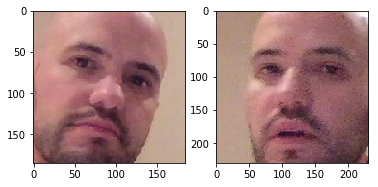

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline

calc_dist_plot('jeremy5', 'jeremy1')
